In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'calorie_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [4]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report

In [7]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier

# Convert y and groups to pandas Series if they are not already
if not isinstance(y, pd.Series):
    y = pd.Series(y)
if not isinstance(groups, pd.Series):
    groups = pd.Series(groups)

logo = LeaveOneGroupOut()
user_auc_scores = []

for train_index, test_index in logo.split(X, y, groups=groups):
    # Splitting the data based on user groups
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    group_test = groups.iloc[test_index]

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Calculate AUC
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"User {group_test.iloc[0]} AUC: {auc}")
    except ValueError:
        auc = 0
        print(f"User {group_test.iloc[0]} AUC: Unable to calculate AUC due to single class in y_test")

    # Store the PID and its AUC score
    user_auc_scores.append((group_test.iloc[0], auc))

# Convert the results into a DataFrame to make sorting easier
user_auc_df = pd.DataFrame(user_auc_scores, columns=['PID', 'AUC'])

# IQR Method to find outliers
Q1 = user_auc_df['AUC'].quantile(0.25)
Q3 = user_auc_df['AUC'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower bound for outliers
lower_bound = Q1 - 1.5 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users)

User P001 AUC: 0.7529906956136464
User P002 AUC: 0.7277745308136893
User P003 AUC: 0.7936176142697882
User P007 AUC: 0.7547892720306513
User P008 AUC: 0.7528046421663444
User P009 AUC: 0.7077731092436975
User P010 AUC: 0.8391911410688493
User P011 AUC: 0.7814893617021277
User P013 AUC: 0.6839176829268293
User P014 AUC: 0.6755347593582888
User P015 AUC: 0.7484304150680153
User P016 AUC: 0.847251461988304
User P018 AUC: 0.695169983416252
User P019 AUC: 0.8387619948641708
User P020 AUC: 0.6978466517301469
User P021 AUC: 0.6690863579474344
User P022 AUC: 0.6623411371237459
User P023 AUC: 0.7347356664184661
User P024 AUC: 0.7713609467455622
User P025 AUC: 0.8156810035842293
User P026 AUC: 0.8945409429280397
User P027 AUC: 0.7767206477732793
User P028 AUC: 0.7636316872427984
User P029 AUC: 0.752156602521566
User P030 AUC: 0.7277797141861275
User P033 AUC: 0.6744087837837838
User P034 AUC: 0.7770256410256411
User P035 AUC: 0.6839239571797712
User P037 AUC: 0.7737003058103975
User P038 AUC: 0.

In [8]:
# Define the lower bound for outliers
lower_bound = Q1 - 1 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

Lowest performing users based on IQR method:
      PID       AUC
32   P042  0.578409
56   P071  0.575858
64   P079  0.518732
80   P101  0.620700
102  P127  0.587585


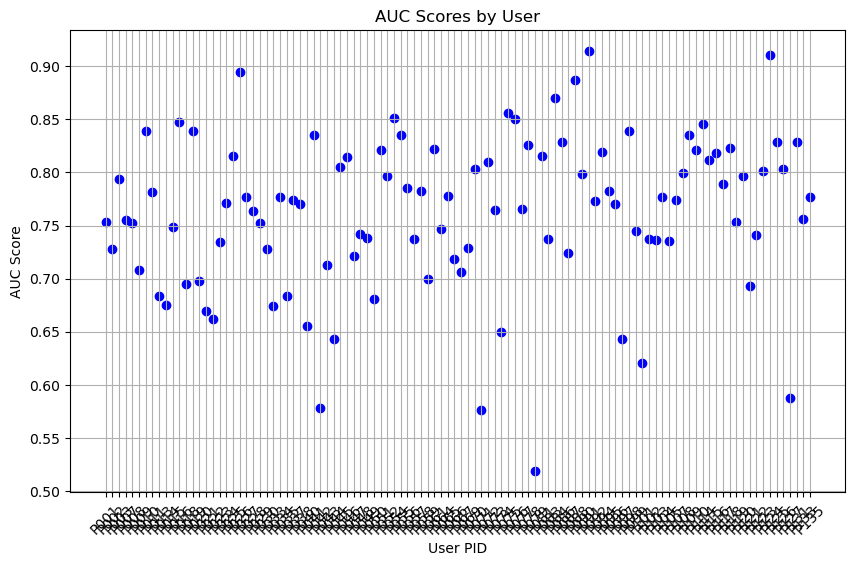

In [9]:
import matplotlib.pyplot as plt

pids, auc_scores = zip(*user_auc_scores)
plt.figure(figsize=(10, 6))
plt.scatter(pids, auc_scores, color='blue')

# Add labels and title
plt.xlabel('User PID')
plt.ylabel('AUC Score')
plt.title('AUC Scores by User')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)  
plt.show()

In [10]:
import pandas as pd

# Assuming X is your DataFrame

# List of prefixes to filter
prefixes = ['SCR', 'PWR', 'CHG', 'BAT', 'LOC']

# Filter columns based on the prefixes
filtered_columns = [col for col in X.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Create a new DataFrame with the filtered columns
filtered_df = X[filtered_columns]

X_fil = filtered_df

In [11]:
X_fil = X_fil[[col for col in X_fil.columns if not col.endswith('#ImmediatePast_15')]]

In [12]:
cn = X_fil.columns.tolist()
print(cn)

['BAT_STA#DSC', 'BAT_STA#DSC=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_PLG#DSC', 'BAT_PLG#DSC=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#DSC', 'LOC_LABEL#DSC=noneworkhome', 'SCR_EVENT#DSC', 'SCR_EVENT#DSC=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'CHG#DSC', 'CHG#DSC=DISCONNECTED', 'CHG#DSC=CONNECTED', 'PWR#DSC', 'PWR#DSC=ACTIVATE', 'PWR#DSC=DEACTIVATE', 'BAT_LEV#VAL', 'BAT_STA#VAL=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_TMP#VAL', 'BAT_PLG#VAL=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#VAL=noneworkhome', 'SCR_EVENT#VAL=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'SCR_DUR#VAL', 'CHG#VAL=DISCONNECTED', 'CHG#VAL=CONNECTED', 'PWR#VAL=ACTIVATE', 'PWR#VAL=DEACTIVATE']


In [13]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# # Function to compare trends for each feature
# def analyze_feature_trends(cn, X_low, X_high):
#     for feature in cn:
#         print(f"\nAnalyzing Feature: {feature}")
        
#         # Check if the feature is in X
#         if feature not in X.columns:
#             print(f"Feature {feature} not found in dataset!")
#             continue
        
#         # Separate the feature values for low and high-performing users
#         low_vals = X_low[feature]
#         high_vals = X_high[feature]

#         # If the feature is numeric, compare means
#         if np.issubdtype(low_vals.dtype, np.number):
#             low_mean = low_vals.mean()
#             high_mean = high_vals.mean()
#             print(f"Low-performing Mean: {low_mean}, High-performing Mean: {high_mean}")
            
#             # Plot the distribution for both
#             plt.figure(figsize=(10, 6))
#             plt.hist(low_vals, bins=30, alpha=0.5, label='Low-performing', color='red')
#             plt.hist(high_vals, bins=30, alpha=0.5, label='High-performing', color='blue')
#             plt.title(f'Distribution of {feature}')
#             plt.legend()
#             plt.show()
        
#         # If the feature is categorical, compare value counts
#         else:
#             low_counts = low_vals.value_counts(normalize=True)
#             high_counts = high_vals.value_counts(normalize=True)
#             comparison = pd.DataFrame({'Low-performing': low_counts, 'High-performing': high_counts}).fillna(0)
#             print(comparison)
            
#             # Plot the comparison
#             comparison.plot(kind='bar', figsize=(10, 6), title=f'{feature} Comparison')
#             plt.show()

# # Apply the analysis to the feature list
# analyze_feature_trends(cn, X_low, X_high)


In [14]:
!pip install slicer

correlation

Training RandomForest for low-performing users...
Training RandomForest for high-performing users...
Importance_low shape: (230,)
Importance_high shape: (230,)
Features shape: (230,)
Feature Importance Comparison between Low and High Performing Users using SHAP:
                                    Feature  Importance_low  Importance_high  \
29                                 RING#DSC        0.005756         0.000186   
68                              SCR_DUR#VAL        0.005119         0.000124   
199            SCR_DUR#ASC#ImmediatePast_15        0.006707         0.002160   
27                            SCR_EVENT#DSC        0.006506         0.002268   
59                             DATA_SNT#VAL        0.004493         0.000373   
23                             CALL_CNT#DSC        0.006622         0.002808   
25                            LOC_LABEL#DSC        0.004646         0.000889   
224  Notification_CAT#ETP##ImmediatePast_15        0.004048         0.000363   
38               

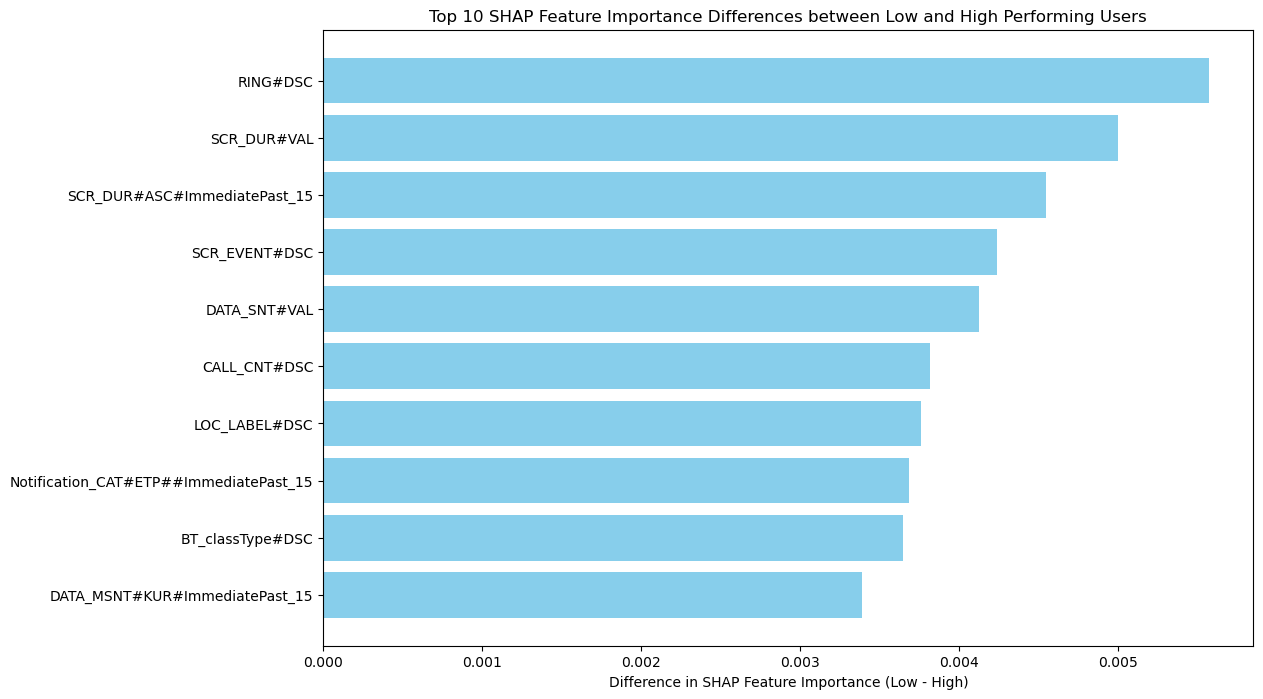

In [16]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
lowest_performing_pids = lowest_performing_users['PID']

# Create DataFrames for the low-performing and high-performing users using the groups array
X_low = X[groups.isin(lowest_performing_pids)]
X_high = X[~groups.isin(lowest_performing_pids)]

y_low = y[groups.isin(lowest_performing_pids)]
y_high = y[~groups.isin(lowest_performing_pids)]

# Train the model for low-performing users
print("Training RandomForest for low-performing users...")
rf_model_low = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model_low.fit(X_low, y_low)

# Train the model for high-performing users
print("Training RandomForest for high-performing users...")
rf_model_high = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model_high.fit(X_high, y_high)

# Initialize the SHAP explainer for both models
explainer_low = shap.TreeExplainer(rf_model_low)
explainer_high = shap.TreeExplainer(rf_model_high)

# Calculate SHAP values for the features in both low and high-performing groups
# For binary classification, shap_values returns a list with two arrays (for classes 0 and 1)
shap_values_low = explainer_low.shap_values(X_low)
shap_values_high = explainer_high.shap_values(X_high)

# Use SHAP values for the positive class (class 1)
shap_values_low_pos = shap_values_low[1]
shap_values_high_pos = shap_values_high[1]

# Calculate mean absolute SHAP values for each feature to get the feature importance
importance_low = np.abs(shap_values_low_pos).mean(axis=0)
importance_high = np.abs(shap_values_high_pos).mean(axis=0)

# Ensure arrays are 1-dimensional
print("Importance_low shape:", importance_low.shape)
print("Importance_high shape:", importance_high.shape)
print("Features shape:", X_low.columns.shape)

# Convert the SHAP values into a DataFrame for easy comparison
features = X_low.columns  # Assuming X_low and X_high have the same columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_low': importance_low,
    'Importance_high': importance_high
})

# Calculate the difference in importance between low and high-performing users
importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']

# Sort by the difference in importance
importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# Display the top features that differ the most
print("Feature Importance Comparison between Low and High Performing Users using SHAP:")
print(importance_df.head(10))  # Display top 10 features

# Optionally, plot the feature importance differences
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:10], importance_df['Importance_diff'][:10], color='skyblue')
plt.xlabel('Difference in SHAP Feature Importance (Low - High)')
plt.title('Top 10 SHAP Feature Importance Differences between Low and High Performing Users')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest difference on top
plt.show()

In [17]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# y_low = y[np.isin(groups, lowest_performing_pids)]
# y_high = y[~np.isin(groups, lowest_performing_pids)]

# # Create DMatrix for low and high-performing users
# dtrain_low = xgb.DMatrix(X_low, label=y_low)
# dtrain_high = xgb.DMatrix(X_high, label=y_high)

# # Set up common XGBoost parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'eta': 0.1,
#     'max_depth': 6
# }

# # Train the model for low-performing users
# print("Training XGBoost for low-performing users...")
# model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# # Train the model for high-performing users
# print("Training XGBoost for high-performing users...")
# model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# # Get feature importance for both models
# importance_low = model_low.get_score(importance_type='weight')
# importance_high = model_high.get_score(importance_type='weight')

# # Convert the feature importance into a DataFrame for easy comparison
# importance_df_low = pd.DataFrame(list(importance_low.items()), columns=['Feature', 'Importance_low'])
# importance_df_high = pd.DataFrame(list(importance_high.items()), columns=['Feature', 'Importance_high'])

# # Merge both importance DataFrames to compare
# importance_df = pd.merge(importance_df_low, importance_df_high, on='Feature', how='outer').fillna(0)

# # Sort by the difference in importance
# importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']
# importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# # Display the top features that differ the most
# print("Feature Importance Comparison between Low and High Performing Users:")
# print(importance_df)

# # Plot the feature importance comparison
# plt.figure(figsize=(12, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
# plt.xlabel('Difference in Feature Importance (Low - High)')
# plt.title('Feature Importance Difference between Low and High Performing Users')
# plt.show()

In [18]:
importance_df = importance_df.sort_values(by='Importance_diff', ascending=True)
importance_df

,Feature,Importance_low,Importance_high,Importance_diff
150,DATA_MSNT#STD#ImmediatePast_15,0.002457,0.022598,-0.020140
145,DATA_MRCV#ASC#ImmediatePast_15,0.001859,0.017947,-0.016088
165,LOC_LABEL#ETP##ImmediatePast_15,0.001087,0.015994,-0.014907
142,DATA_MRCV#STD#ImmediatePast_15,0.001586,0.015143,-0.013556
202,SCR_DUR#TSC#ImmediatePast_15,0.002019,0.015199,-0.013180
...,...,...,...,...
59,DATA_SNT#VAL,0.004493,0.000373,0.004120
27,SCR_EVENT#DSC,0.006506,0.002268,0.004238
199,SCR_DUR#ASC#ImmediatePast_15,0.006707,0.002160,0.004547
68,SCR_DUR#VAL,0.005119,0.000124,0.004995


Descriptive Statistics for Low Performing Users:
Mean: 31.682310104370117, Median: 31.200000762939453, Std: 5.02454948425293, Min: 12.899999618530273, Max: 44.900001525878906

Descriptive Statistics for High Performing Users:
Mean: 30.170269012451172, Median: 30.200000762939453, Std: 4.631146430969238, Min: 4.0, Max: 48.599998474121094


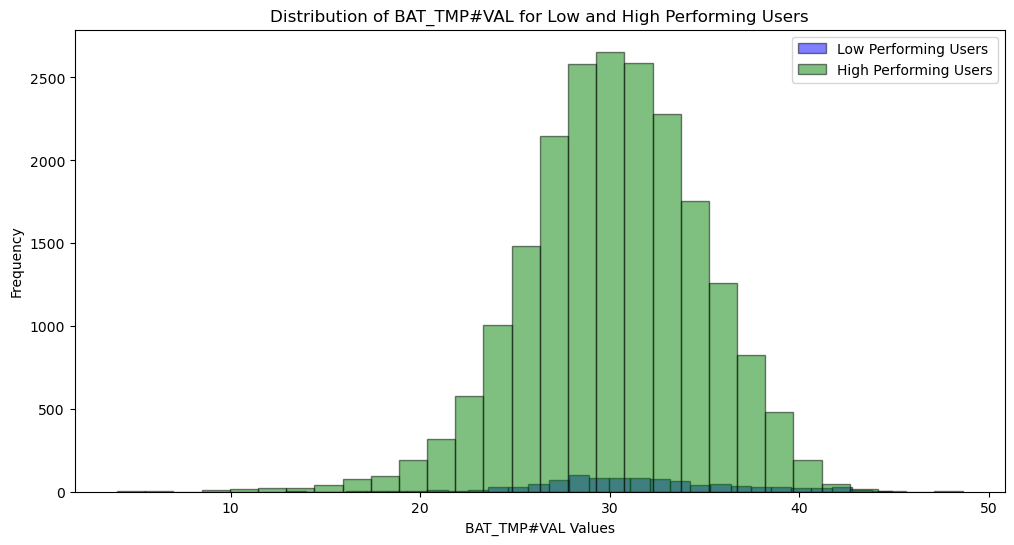

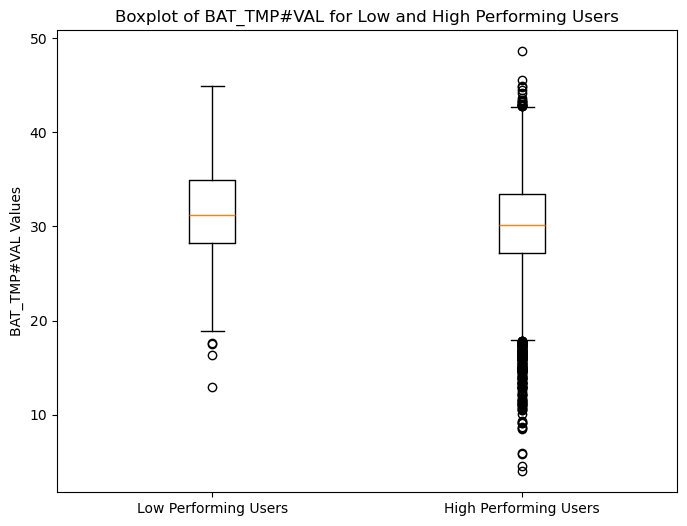

T-test results for BAT_TMP#VAL: t-statistic = 9.06706685105735, p-value = 6.147324705475328e-19
Mann-Whitney U test results for BAT_TMP#VAL: U-statistic = 11189162.0, p-value = 2.3649110188570792e-14
Pearson correlation for low-performing users: -0.19938392524410437
Pearson correlation for high-performing users: -0.27769070831703957


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#VAL'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 7455495.5, Median: 49742.4765625, Std: 173653488.0, Min: 0.0, Max: 5322801152.0

Descriptive Statistics for High Performing Users:
Mean: 21932508.0, Median: 2605.729736328125, Std: 252544096.0, Min: 0.0, Max: 17760813056.0


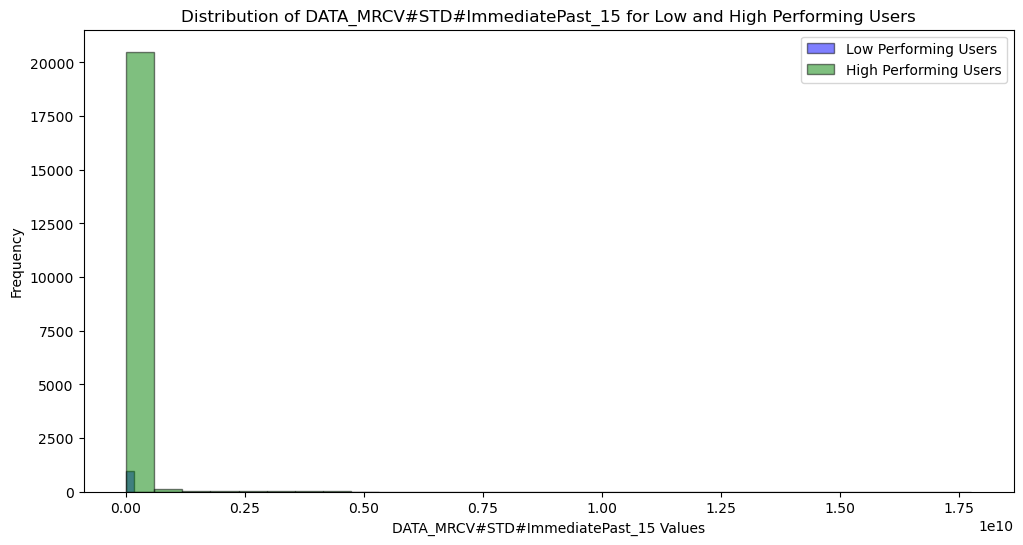

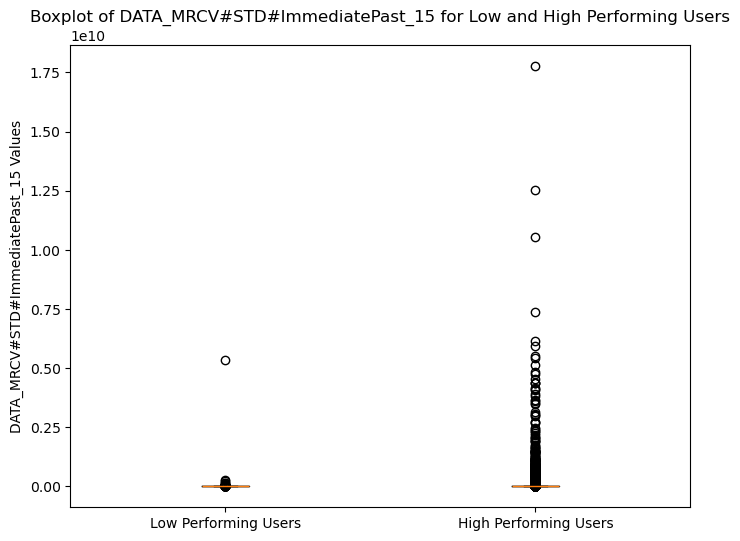

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -2.444844922632578, p-value = 0.014642926842361813
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 11940660.5, p-value = 2.1839227834152345e-31
Pearson correlation for low-performing users: 0.03317754128774395
Pearson correlation for high-performing users: 0.041965583047890456


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 820270.625, Median: 225418.28125, Std: 7016955.5, Min: 0.0, Max: 182197440.0

Descriptive Statistics for High Performing Users:
Mean: 1885649.375, Median: 1564.83544921875, Std: 15506843.0, Min: 0.0, Max: 1101061632.0


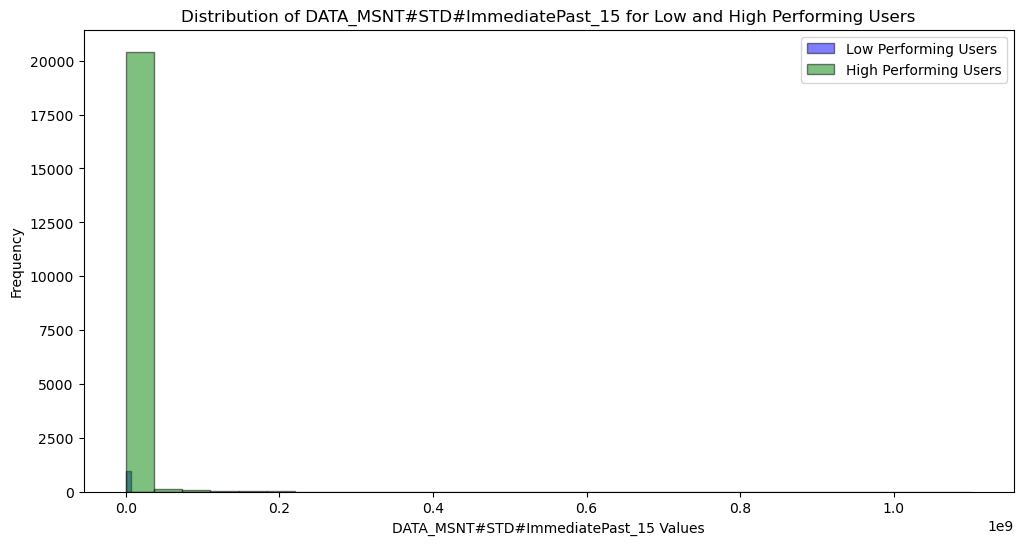

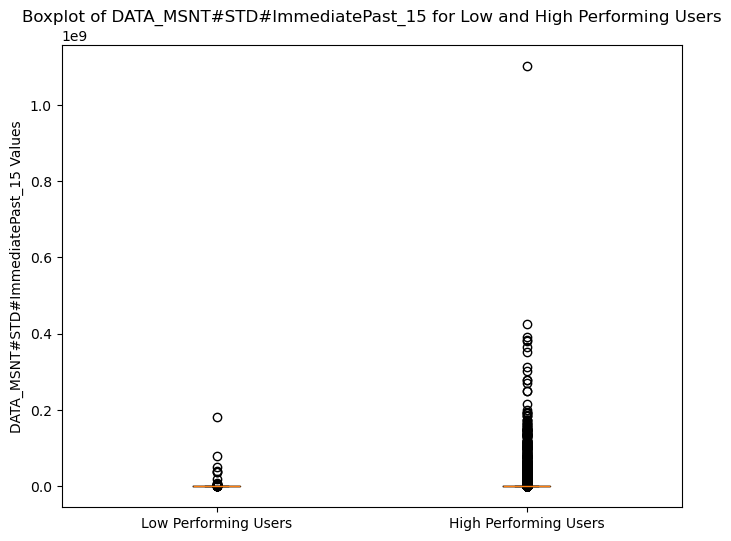

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -4.216407810933507, p-value = 2.6406446268144584e-05
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 12657062.5, p-value = 4.7792826209795987e-54
Pearson correlation for low-performing users: 0.0232105423737666
Pearson correlation for high-performing users: 0.05710362672837511


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


In [22]:
importance_df.head(20)

,Feature,Importance_low,Importance_high,Importance_diff
150,DATA_MSNT#STD#ImmediatePast_15,0.002457,0.022598,-0.020140
145,DATA_MRCV#ASC#ImmediatePast_15,0.001859,0.017947,-0.016088
165,LOC_LABEL#ETP##ImmediatePast_15,0.001087,0.015994,-0.014907
142,DATA_MRCV#STD#ImmediatePast_15,0.001586,0.015143,-0.013556
202,SCR_DUR#TSC#ImmediatePast_15,0.002019,0.015199,-0.013180
141,DATA_MRCV#AVG#ImmediatePast_15,0.001577,0.014499,-0.012922
153,DATA_MSNT#ASC#ImmediatePast_15,0.002503,0.014851,-0.012348
166,LOC_LABEL#ASC##ImmediatePast_15,0.000604,0.011335,-0.010731
149,DATA_MSNT#AVG#ImmediatePast_15,0.002841,0.012699,-0.009858
104,BAT_TMP#STD#ImmediatePast_15,0.005432,0.013863,-0.008431


Descriptive Statistics for Low Performing Users:
Mean: 2.3696346282958984, Median: 2.031284809112549, Std: 2.0016539096832275, Min: 0.0, Max: 12.754207611083984

Descriptive Statistics for High Performing Users:
Mean: 2.550102949142456, Median: 2.3364336490631104, Std: 1.798277735710144, Min: 0.0, Max: 18.208240509033203


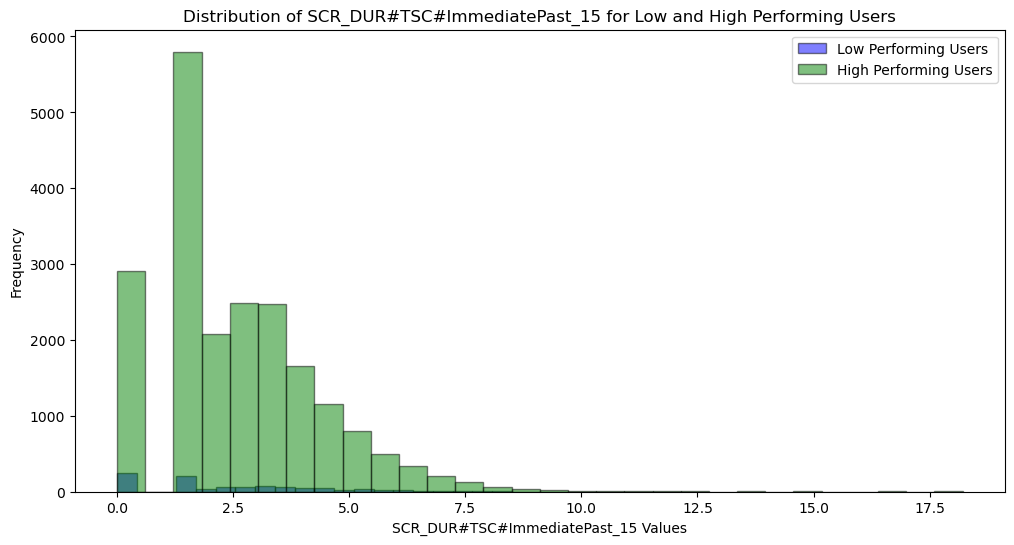

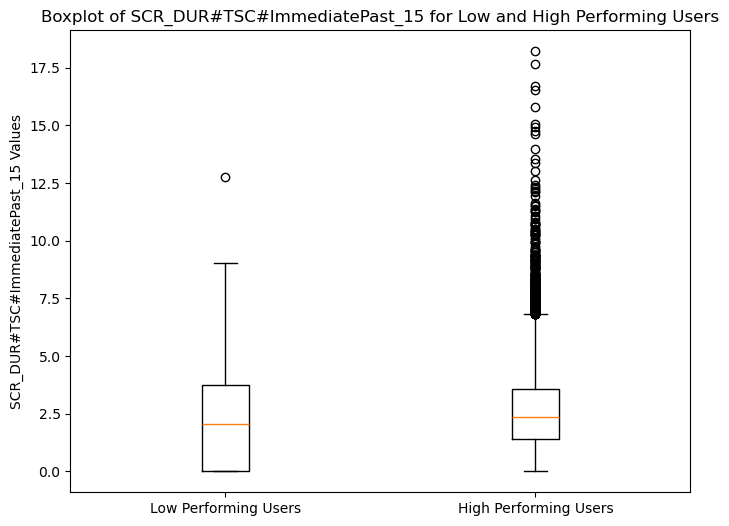

T-test results for SCR_DUR#TSC#ImmediatePast_15: t-statistic = -2.719051423074351, p-value = 0.006658781434813085
Mann-Whitney U test results for SCR_DUR#TSC#ImmediatePast_15: U-statistic = 9094849.0, p-value = 0.00038765334753931586
Pearson correlation for low-performing users: 0.13501330466952188
Pearson correlation for high-performing users: 0.28436765873124176


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#TSC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 7455495.5, Median: 49742.4765625, Std: 173653488.0, Min: 0.0, Max: 5322801152.0

Descriptive Statistics for High Performing Users:
Mean: 21932508.0, Median: 2605.729736328125, Std: 252544096.0, Min: 0.0, Max: 17760813056.0


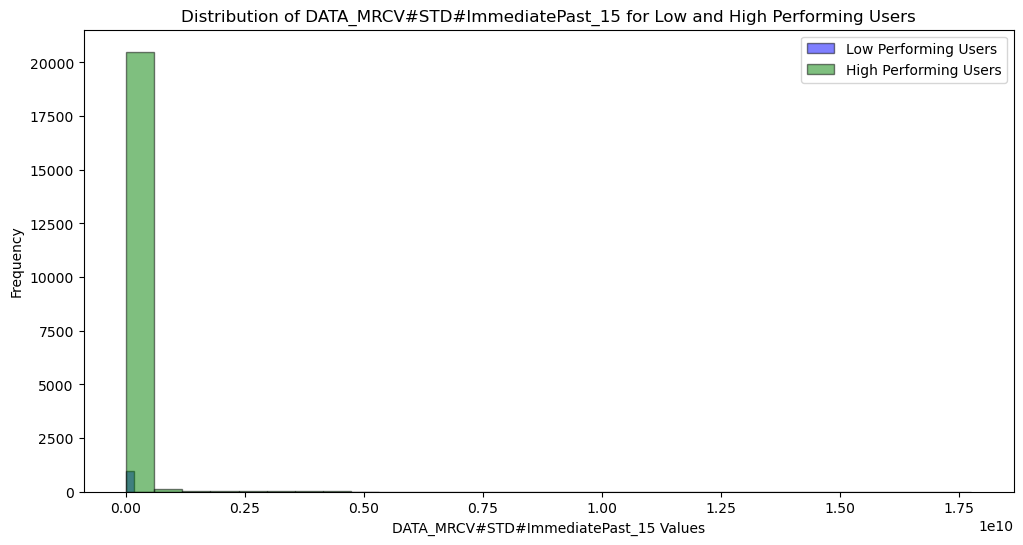

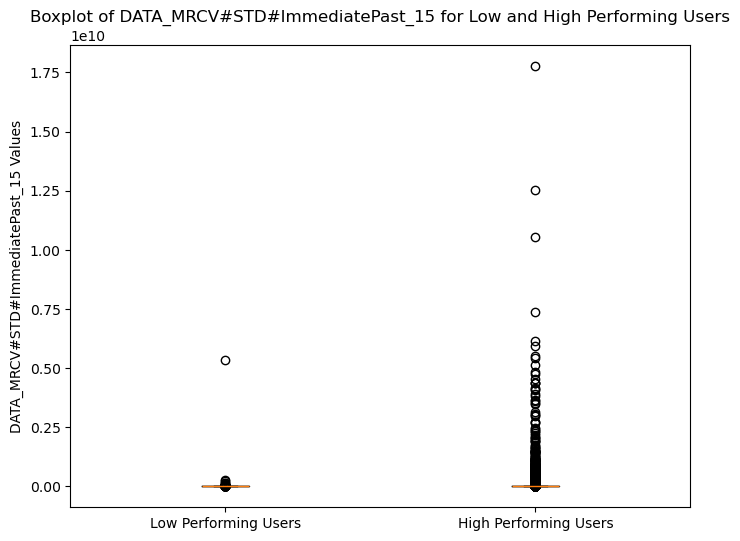

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = -2.444844922632578, p-value = 0.014642926842361813
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 11940660.5, p-value = 2.1839227834152345e-31
Pearson correlation for low-performing users: 0.03317754128774395
Pearson correlation for high-performing users: 0.041965583047890456


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 820270.625, Median: 225418.28125, Std: 7016955.5, Min: 0.0, Max: 182197440.0

Descriptive Statistics for High Performing Users:
Mean: 1885649.375, Median: 1564.83544921875, Std: 15506843.0, Min: 0.0, Max: 1101061632.0


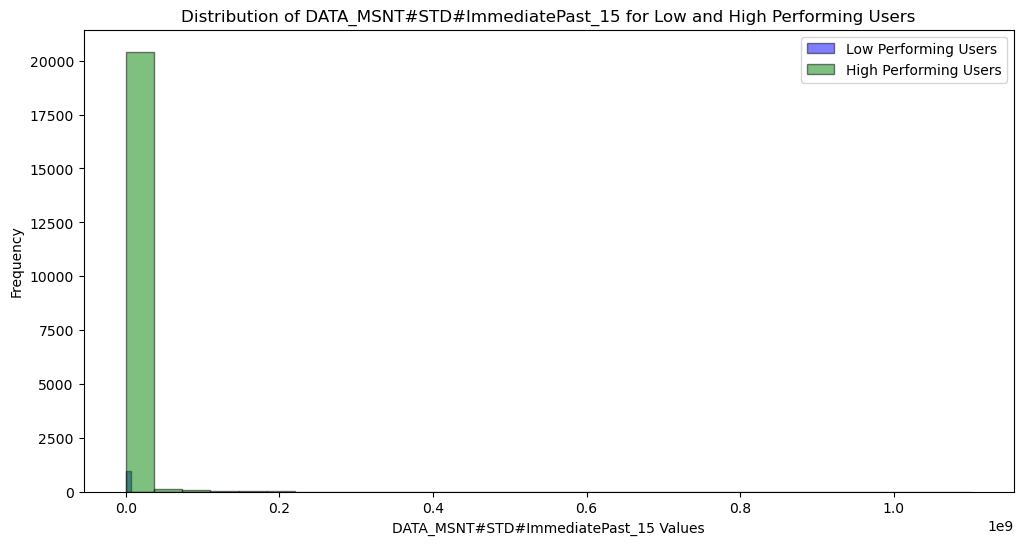

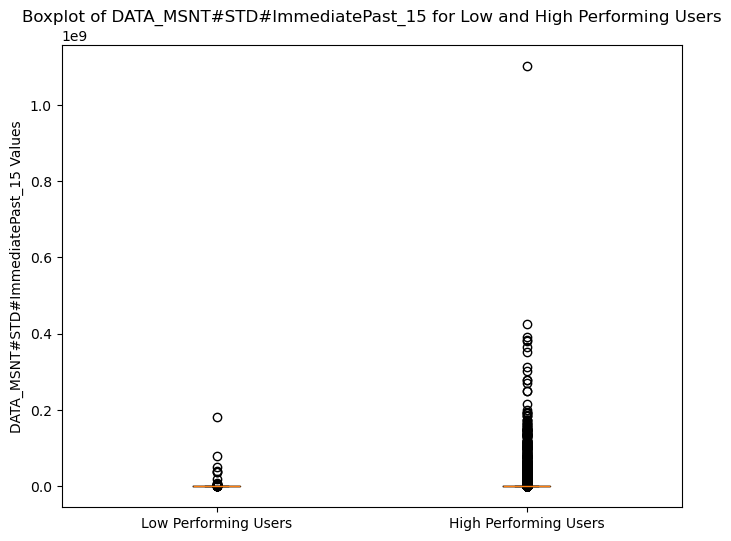

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = -4.216407810933507, p-value = 2.6406446268144584e-05
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 12657062.5, p-value = 4.7792826209795987e-54
Pearson correlation for low-performing users: 0.0232105423737666
Pearson correlation for high-performing users: 0.05710362672837511


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 30.89639663696289, Median: 30.899999618530273, Std: 6.636128902435303, Min: 0.0, Max: 44.70000076293945

Descriptive Statistics for High Performing Users:
Mean: 29.41754913330078, Median: 30.0, Std: 6.365279197692871, Min: 0.0, Max: 48.79999923706055


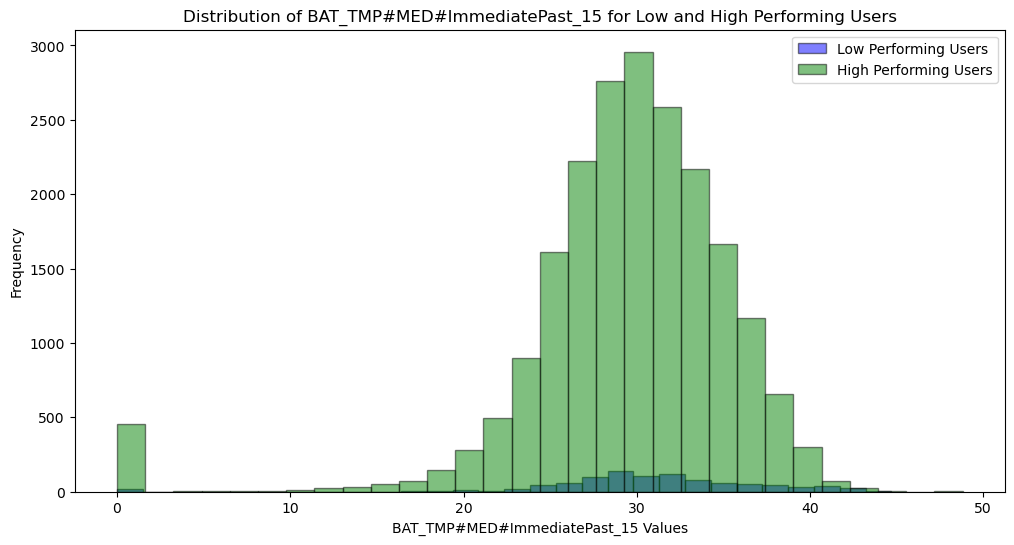

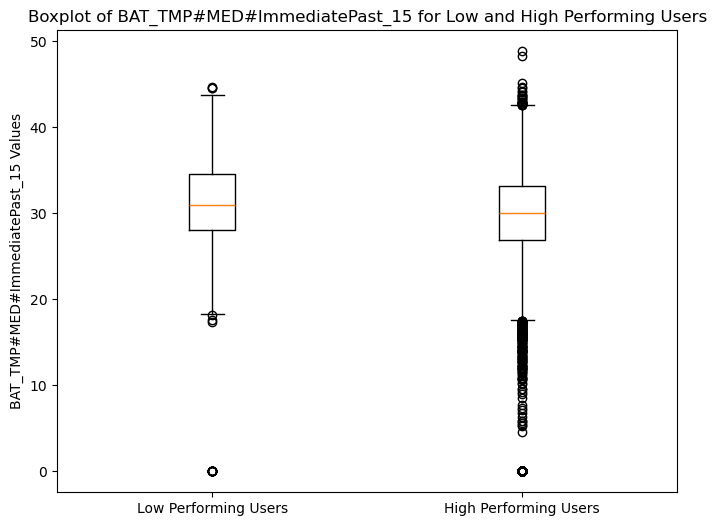

T-test results for BAT_TMP#MED#ImmediatePast_15: t-statistic = 6.704052618526386, p-value = 3.34421911298487e-11
Mann-Whitney U test results for BAT_TMP#MED#ImmediatePast_15: U-statistic = 11078487.5, p-value = 1.9393590410572742e-12
Pearson correlation for low-performing users: -0.15611061636866091
Pearson correlation for high-performing users: -0.1506335707218042


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#MED#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 1876.7415771484375, Median: 1305.620849609375, Std: 4695.4130859375, Min: 0.0, Max: 66975.1328125

Descriptive Statistics for High Performing Users:
Mean: 1594.1063232421875, Median: 1369.386962890625, Std: 1944.826904296875, Min: 0.0, Max: 44371.80859375


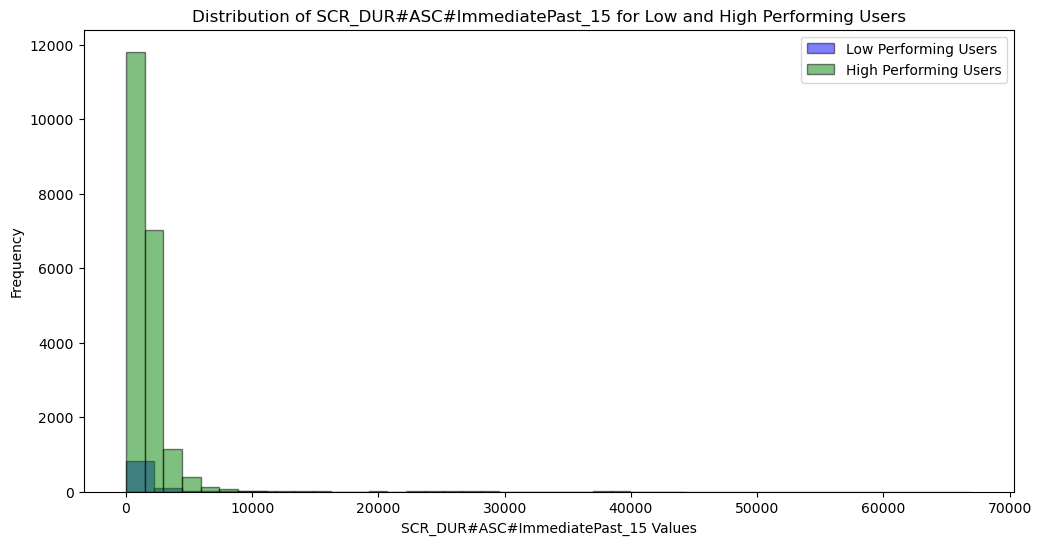

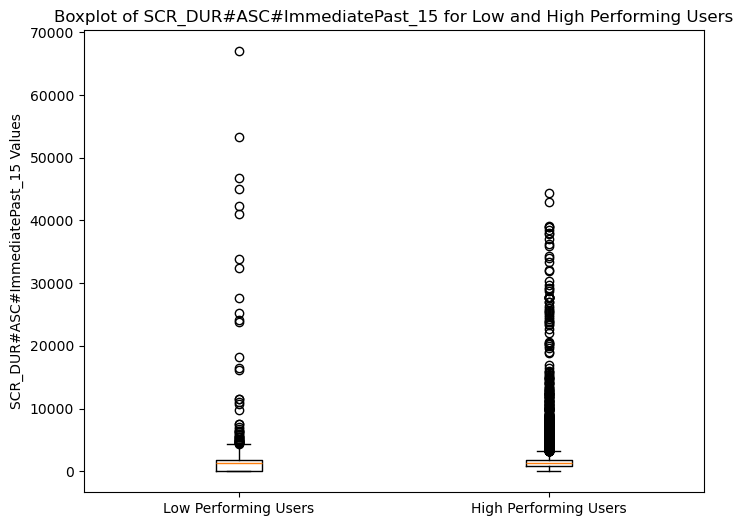

T-test results for SCR_DUR#ASC#ImmediatePast_15: t-statistic = 1.8412660435468617, p-value = 0.06589167514124752
Mann-Whitney U test results for SCR_DUR#ASC#ImmediatePast_15: U-statistic = 8907200.0, p-value = 5.4322543913538166e-06
Pearson correlation for low-performing users: -0.019946501904475347
Pearson correlation for high-performing users: -0.024168366958521998


In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#ASC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 5183.13623046875, Median: 71.19599914550781, Std: 16334.6220703125, Min: 1.1269999742507935, Max: 119310.765625

Descriptive Statistics for High Performing Users:
Mean: 524.5086669921875, Median: 48.35100173950195, Std: 1582.197509765625, Min: 1.6019999980926514, Max: 44205.43359375


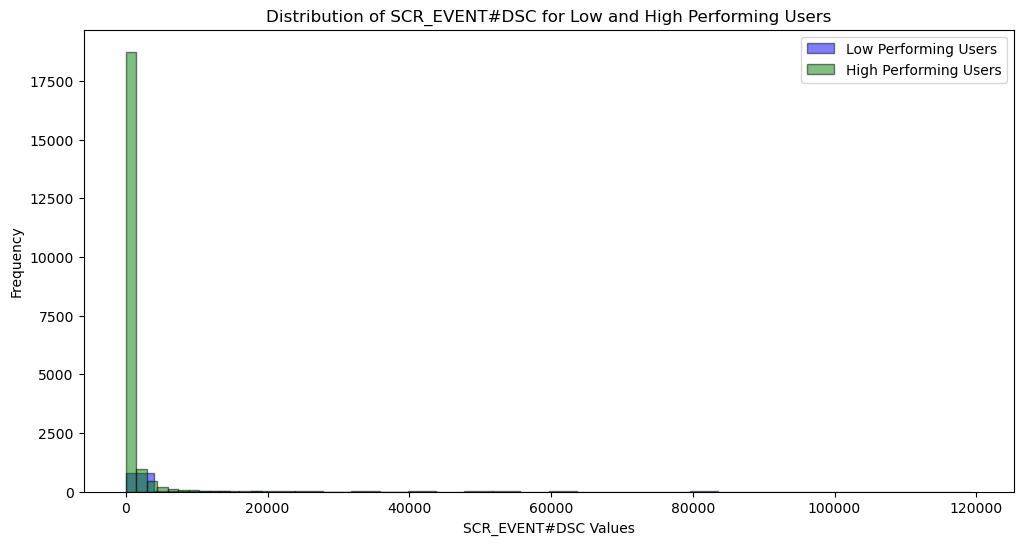

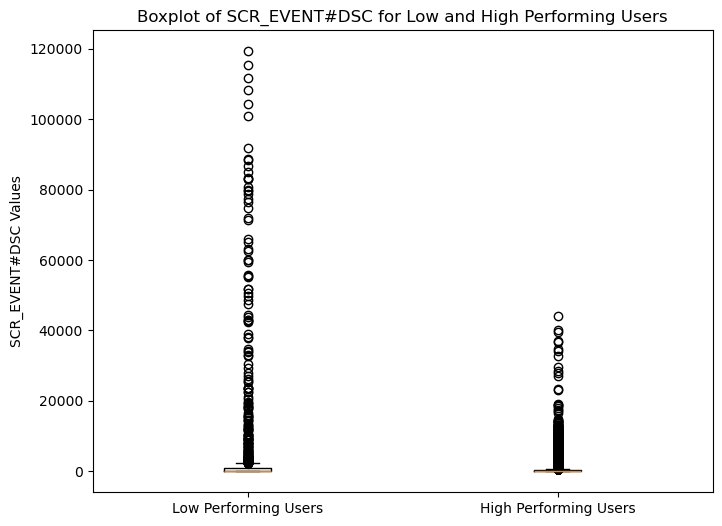

T-test results for SCR_EVENT#DSC: t-statistic = 8.75612101580048, p-value = 9.206257485760276e-18
Mann-Whitney U test results for SCR_EVENT#DSC: U-statistic = 10603720.0, p-value = 6.580019717106083e-06
Pearson correlation for low-performing users: -0.11852480641534238
Pearson correlation for high-performing users: -0.12124588330773295


In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_EVENT#DSC'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 8.90360164642334, Median: 6.0, Std: 9.337722778320312, Min: 0.0, Max: 79.0

Descriptive Statistics for High Performing Users:
Mean: 11.05513858795166, Median: 4.0, Std: 78.62352752685547, Min: 0.0, Max: 3122.0


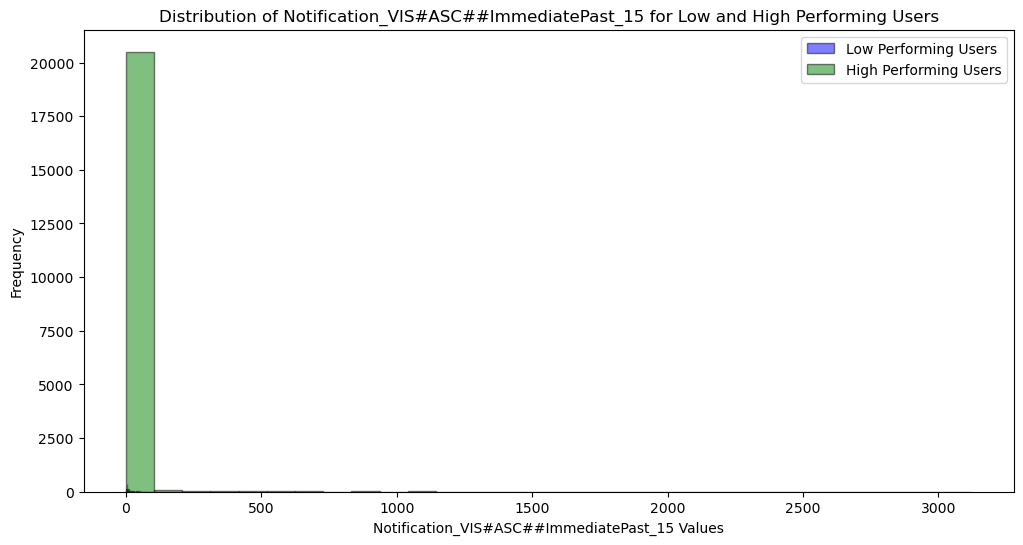

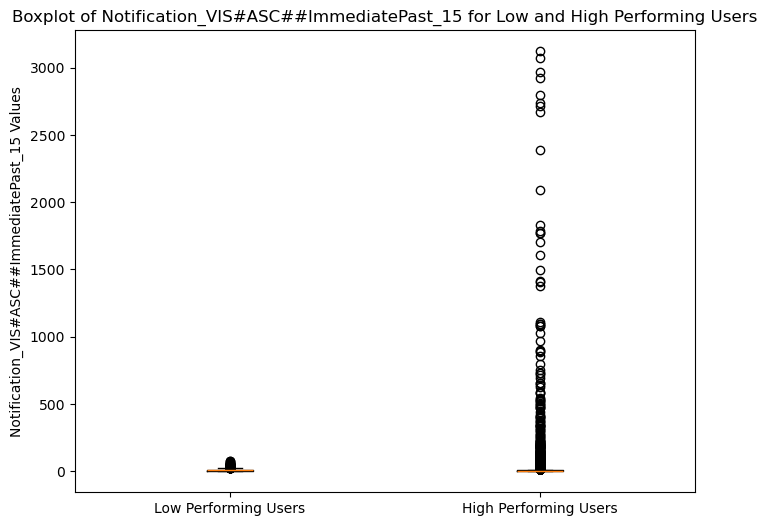

T-test results for Notification_VIS#ASC##ImmediatePast_15: t-statistic = -3.4386919475210527, p-value = 0.0005866141420523623
Mann-Whitney U test results for Notification_VIS#ASC##ImmediatePast_15: U-statistic = 11595900.5, p-value = 6.379552656641209e-23
Pearson correlation for low-performing users: -0.010296601737210923
Pearson correlation for high-performing users: 0.05335267069220052


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'Notification_VIS#ASC##ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")